<a href="https://colab.research.google.com/github/buketugurlu/BUSI/blob/main/unet_BUSIv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20, Loss: 1.2437076228005546
Epoch 2/20, Loss: 0.9277295328321911
Epoch 3/20, Loss: 0.7449418419883365
Epoch 4/20, Loss: 0.5953014166582198
Epoch 5/20, Loss: 0.5164925143832252
Epoch 6/20, Loss: 0.4578627177647182
Epoch 7/20, Loss: 0.3863072097301483
Epoch 8/20, Loss: 0.34485869606335956
Epoch 9/20, Loss: 0.3093387314251491
Epoch 10/20, Loss: 0.2853569381293796
Epoch 11/20, Loss: 0.26135411574727013
Epoch 12/20, Loss: 0.237143908228193
Epoch 13/20, Loss: 0.21690679022244044
Epoch 14/20, Loss: 0.19349366568383716
Epoch 15/20, Loss: 0.17827291431881132
Epoch 16/20, Loss: 0.16297881872881026
Epoch 17/20, Loss: 0.1533829335655485
Epoch 18/20, Loss: 0.15307026072627022
Epoch 19/20, Loss: 0.16916907330354056
Epoch 20/20, Loss: 0.15222342773562386
Doğrulama Metrikleri:
  Dice Skoru: 0.9464
  IOU (Intersection over Union): 0.8982


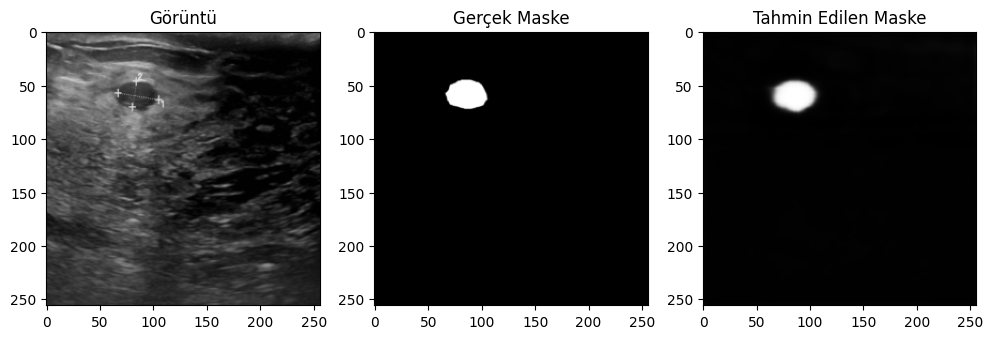

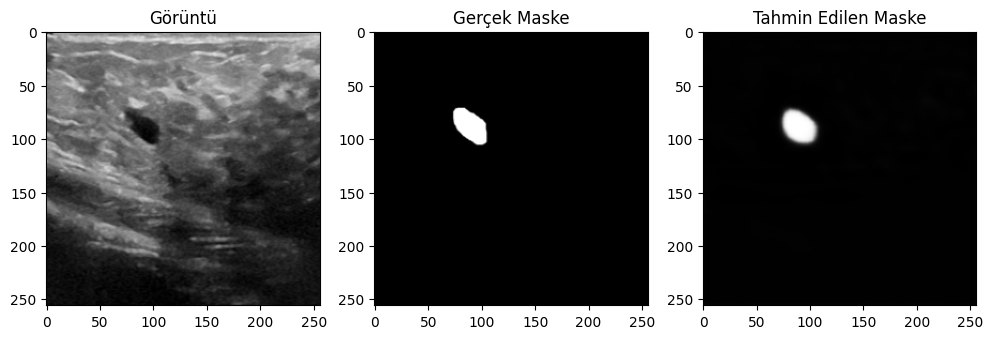

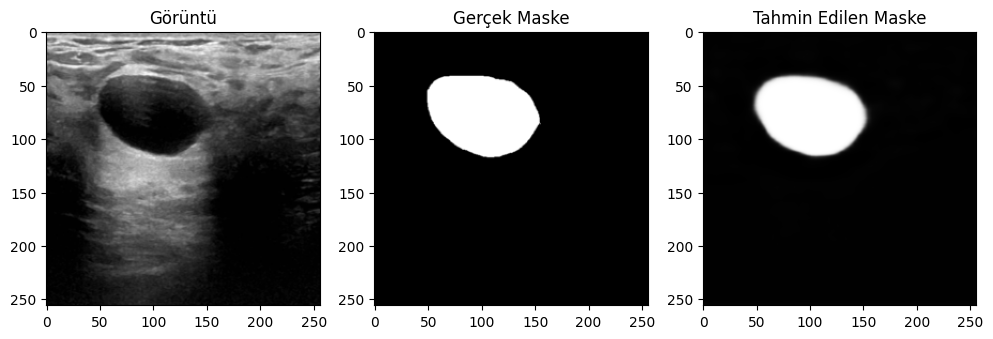

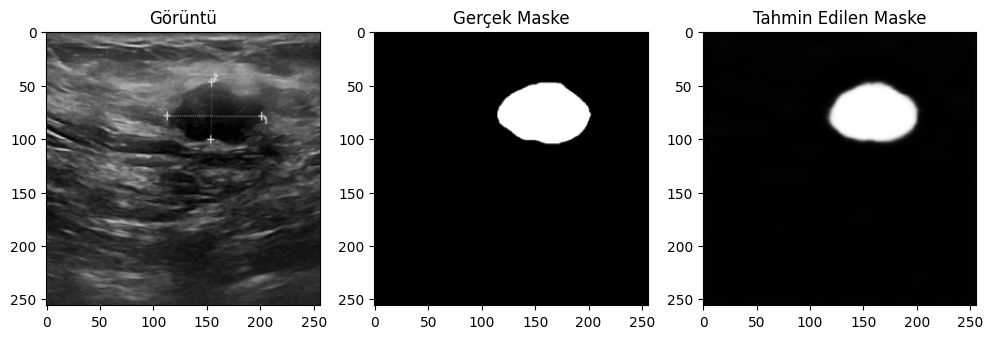

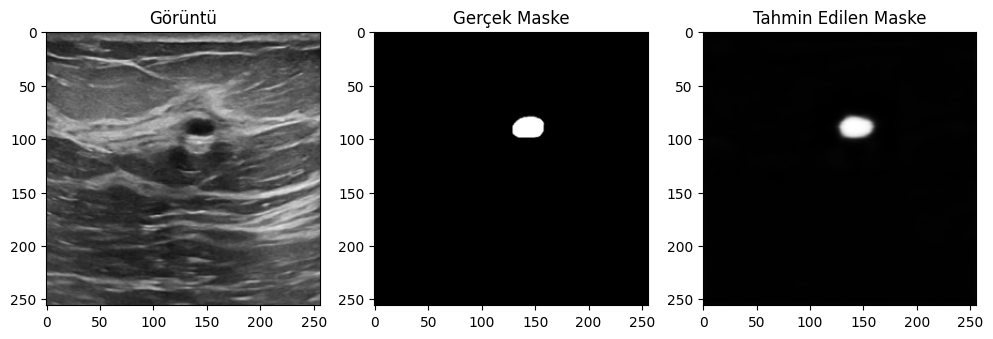

In [15]:
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import numpy as np

# Google Drive'ı mount etme
drive.mount('/content/drive')

# Dataset klasörünü tanımlama
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'

# Dataset için PyTorch Dataset sınıfı tanımlama
class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, classes=['benign', 'malignant'], transform_image=None, transform_mask=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform_image = transform_image  # Görüntüler için dönüşüm
        self.transform_mask = transform_mask  # Maskeler için dönüşüm
        self.image_paths = []
        self.mask_paths = []

        # Sınıflar boyunca görüntü ve maske yollarını yükleme
        for cls in self.classes:
            image_dir = os.path.join(root_dir, cls)
            for filename in os.listdir(image_dir):
                if filename.endswith(".png") and "_mask" not in filename:
                    image_path = os.path.join(image_dir, filename)
                    mask_path = os.path.join(image_dir, filename.replace(".png", "_mask.png"))
                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")  # Görüntüyü RGB'ye dönüştür
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Maskeyi gri tonlamaya dönüştür

        # Dönüşümleri uygula (varsa)
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Görüntü ve maske dönüşümleri
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Dataset oluşturma
dataset = BreastUltrasoundDataset(
    root_dir=base_dir,
    classes=['benign', 'malignant'],
    transform_image=transform_image,
    transform_mask=transform_mask
)

# DataLoader oluşturma
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Model tanımlama
model = smp.DeepLabV3Plus(
    encoder_name="resnet152",        # Encoder tipi
    encoder_weights="imagenet",     # Pretrained ağırlıklar
    in_channels=3,                   # Giriş kanalı sayısı (RGB)
    classes=1                        # Çıkış sınıfı sayısı (binary segmentasyon)
)

# Kayıp fonksiyonu ve optimizasyon
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = torch.nn.BCEWithLogitsLoss()

class SegmentationModel(torch.nn.Module):
    def __init__(self, model, dice_loss, bce_loss):
        super(SegmentationModel, self).__init__()
        self.model = model
        self.dice_loss = dice_loss
        self.bce_loss = bce_loss

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, predictions, masks):
        loss_dice = self.dice_loss(predictions, masks)
        loss_bce = self.bce_loss(predictions, masks)
        return loss_dice + loss_bce

lightning_model = SegmentationModel(model, dice_loss, bce_loss).cuda()

# Model eğitimi için optimizasyon
optimizer = torch.optim.Adam(lightning_model.parameters(), lr=1e-4)

# Eğitim döngüsü
num_epochs = 20
for epoch in range(num_epochs):
    lightning_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        predictions = lightning_model(images)
        loss = lightning_model.compute_loss(predictions, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Modeli kaydetme
torch.save(lightning_model.state_dict(), '/content/drive/My Drive/Dataset_BUSI_with_GT/deeplabv3_model.pth')

# Tahminleri görselleştirme ve doğrulama metriklerini hesaplama
lightning_model.eval()
def evaluate_model(dataset, model, num_samples=100):
    all_preds = []
    all_masks = []
    for i in range(min(num_samples, len(dataset))):
        image, mask = dataset[i]
        image = image.unsqueeze(0).cuda()  # Batch boyutunu ekle ve CUDA'ya taşı
        with torch.no_grad():
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Sigmoid uygulama ve CPU'ya taşı
            prediction_binary = (prediction > 0.5).astype(np.uint8)

        all_preds.append(prediction_binary.flatten())
        all_masks.append(mask.numpy().flatten())  # `mask`'i NumPy dizisine dönüştürün

    # Doğrulama metrikleri
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)  # İkili değerlere dönüştür

    # Özel metrikler
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    dice_score = (2.0 * intersection) / (y_true.sum() + y_pred.sum() + 1e-6)
    iou = intersection / (union + 1e-6)

    print("Doğrulama Metrikleri:")
    print(f"  Dice Skoru: {dice_score:.4f}")
    print(f"  IOU (Intersection over Union): {iou:.4f}")


def visualize_predictions(dataset, model, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.unsqueeze(0).cuda()  # Batch boyutunu ekle ve CUDA'ya taşı
        with torch.no_grad():
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Sigmoid uygulama ve CPU'ya taşı
        plt.figure(figsize=(12, 4))

        # Orijinal görüntü
        plt.subplot(1, 3, 1)
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())  # CHW'den HWC'ye dönüştür
        plt.title("Görüntü")

        # Gerçek maske
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap='gray')
        plt.title("Gerçek Maske")

        # Tahmin edilen maske
        plt.subplot(1, 3, 3)
        plt.imshow(prediction, cmap='gray')
        plt.title("Tahmin Edilen Maske")

        plt.show()

# Doğrulama ve görselleştirme
evaluate_model(dataset, lightning_model)
visualize_predictions(dataset, lightning_model)


In [16]:
def evaluate_model_with_extended_metrics(dataset, model, num_samples=100):
    all_preds = []
    all_masks = []
    for i in range(min(num_samples, len(dataset))):
        image, mask = dataset[i]
        image = image.unsqueeze(0).cuda()  # Batch boyutunu ekle ve CUDA'ya taşı
        with torch.no_grad():
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Sigmoid uygulama ve CPU'ya taşı
            prediction_binary = (prediction > 0.5).astype(np.uint8)

        all_preds.append(prediction_binary.flatten())
        all_masks.append(mask.numpy().flatten())

    # Doğrulama metrikleri
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    # Ek metrikler
    tn = np.logical_and(y_true == 0, y_pred == 0).sum()
    fp = np.logical_and(y_true == 0, y_pred == 1).sum()
    specificity = tn / (tn + fp + 1e-6)
    balanced_accuracy = (recall + specificity) / 2
    jaccard_index = (precision * recall) / (precision + recall - (precision * recall) + 1e-6)

    print("Doğrulama Metrikleri (Genişletilmiş):")
    print(f"  Doğruluk (Accuracy): {accuracy:.4f}")
    print(f"  Kesinlik (Precision): {precision:.4f}")
    print(f"  Geri Çağırma (Recall): {recall:.4f}")
    print(f"  F1 Skoru: {f1:.4f}")
    print(f"  Seçicilik (Specificity): {specificity:.4f}")
    print(f"  Dengeli Doğruluk (Balanced Accuracy): {balanced_accuracy:.4f}")
    print(f"  Jaccard Index (IoU): {jaccard_index:.4f}")

# Yeni metrikleri hesaplama
evaluate_model_with_extended_metrics(dataset, lightning_model)


Doğrulama Metrikleri (Genişletilmiş):
  Doğruluk (Accuracy): 0.9949
  Kesinlik (Precision): 0.9289
  Geri Çağırma (Recall): 0.9645
  F1 Skoru: 0.9464
  Seçicilik (Specificity): 0.9964
  Dengeli Doğruluk (Balanced Accuracy): 0.9804
  Jaccard Index (IoU): 0.8982
